In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from model import print_results, MonoexponentialModel, make_exp_data

In [2]:
class MultiexponentialModel(tf.keras.Model):
    def __init__(self, 
                 filling_pulse=20 * 10 ** (-6), 
                 M=5.861,
                 n_exps=1, 
                 **kwargs):
        super().__init__(**kwargs)
        
        self.exps_list = list()
        
        for _ in range(n_exps):
            self.exps_list.append(MonoexponentialModel(filling_pulse=filling_pulse, M=M))
            
    def call(self, frequency):
        dlts = 0.0
        for i in self.exps_list:
            dlts += i(frequency)
        
        return dlts

In [3]:
def make_multiexp_data(time_constant_list, 
                       amp_list, 
                       f_pulse, 
                       std_dev, 
                       num_points):
    dlts_list = list()
    
    for time_constant, amplitude in zip(time_constant_list, amp_list):
        
        frequency, temp_actual_dlts = make_exp_data(f_pulse = f_pulse,
                                                    time_constant = time_constant,
                                                    ampl = amplitude,
                                                    std_dev = std_dev,
                                                    num_ex = num_points
                                                   )
        
        dlts_list.append(temp_actual_dlts)
        
    actual_dlts = 0.0
    for i in dlts_list:
        actual_dlts += i

    return frequency, actual_dlts

In [4]:
def print_multiexp(frequency, actual_dlts, final_model, history):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10))

    ax0.semilogx(frequency, actual_dlts, '.g', label="Actual values", alpha=0.3)
    ax0.semilogx(frequency, final_model(frequency), 'r', label="Final model")

    for n, i in enumerate(final_model.exps_list):
        time_constant_power = i.time_constant_power.numpy()
        print(f'Moldel {n} Time constant {10**time_constant_power}')
        print(f'Model {n} Amplitude: {i.amplitude.numpy():.4f} pF')
        print("\n")

    final_mse = tf.keras.metrics.mean_squared_error(actual_dlts, final_model(frequency))
    print(f'Final RMSE = {tf.sqrt(final_mse):.6f}')
        
    for n, i in enumerate(final_model.exps_list):
        ax0.semilogx(frequency, i(frequency), '--b', label=f"Exp {n}", alpha=1)
        
    ax0.set_xlabel('Frequency, Hz')
    ax0.set_ylabel('DLTS')

    ax0.legend()
    
    
    ax1.plot(history.history['loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss [Mean Squared Error]')
    
    ax0.grid()
    ax1.grid()
    
    return fig, (ax0, ax1)

# Общие параметры моделирования

In [5]:
NUM_EXAMPLES = 1000

TIME_CONSTANT0 = 0.2
TIME_CONSTANT1 = 0.008
TIME_CONSTANT2 = 0.0004

AMPL0 = 3.0
AMPL1 = 2.5
AMPL2 = 2.0

F_PULSE = 20 * 10 ** (-6)

STD_DEV = 0.2

LEARNING_RATE = 0.1
EPOCHS = 100
BATCH_SIZE = 100

N_EXPS = 3

# Генерация экспериментальных данных

In [6]:
frequency, actual_dlts = make_multiexp_data(time_constant_list = [TIME_CONSTANT0, TIME_CONSTANT1, TIME_CONSTANT2], 
                                            amp_list = [AMPL0, AMPL1, AMPL2], 
                                            f_pulse = F_PULSE, 
                                            std_dev = STD_DEV, 
                                            num_points = NUM_EXAMPLES)

# Модель до оптимизации параметров

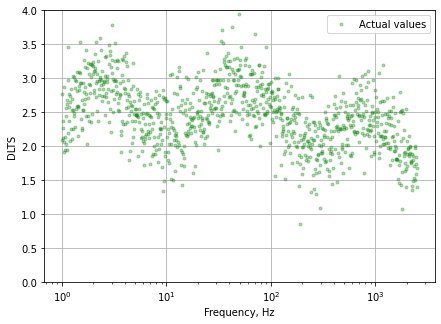

In [7]:
plt.figure(figsize=(7,5))
plt.semilogx(frequency, actual_dlts, '.g', label="Actual values", alpha=0.3)
plt.xlabel('Frequency, Hz')
plt.ylabel('DLTS')
plt.ylim(0, 4)
plt.xlabel('Frequency, Hz')
plt.ylabel('DLTS')
plt.legend()
plt.grid()
# plt.savefig('plots/monoexponential/multiexp_experimental_data.svg')
plt.show()

# Оптимизация модели простым градиентным спуском

Moldel 0 Time constant 0.20450065083805713
Model 0 Amplitude: 2.9652 pF


Moldel 1 Time constant 0.00039627590402776917
Model 1 Amplitude: 2.0029 pF


Moldel 2 Time constant 0.008033095090147801
Model 2 Amplitude: 2.5454 pF


Final RMSE = 0.341212


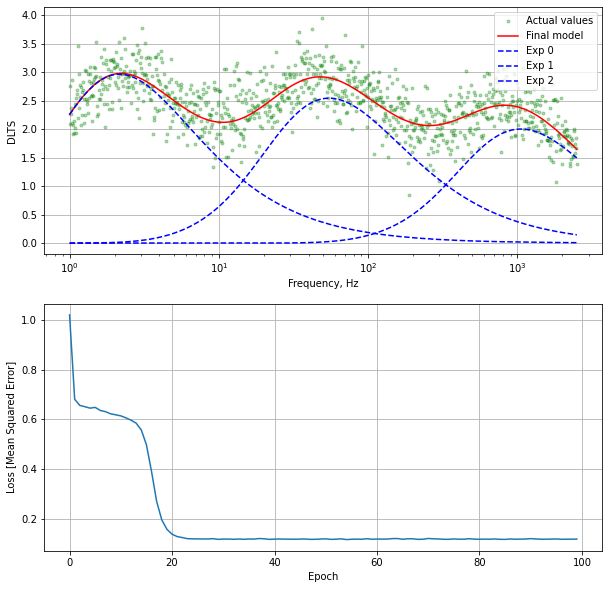

In [8]:
final_model = MultiexponentialModel(filling_pulse=F_PULSE, n_exps=N_EXPS)

final_model.compile(run_eagerly=False,
                    loss=tf.keras.losses.MSE,
                    optimizer=tf.optimizers.SGD(learning_rate=LEARNING_RATE))

history = final_model.fit(frequency, actual_dlts, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)

fig, ax = print_multiexp(frequency, actual_dlts, final_model, history)

# plt.savefig('plots/monoexponential/multiexp_SGD.svg')
plt.show()

# Оптимизация параметров модели алгоритмом Adagrad

In [9]:
# final_model = MultiexponentialModel(filling_pulse=F_PULSE, n_exps=N_EXPS)

# final_model.compile(run_eagerly=False,
#                     loss=tf.keras.losses.MSE,
#                     optimizer=tf.optimizers.Adagrad(learning_rate=LEARNING_RATE))

# history = final_model.fit(frequency, actual_dlts, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)

# fig, ax = print_multiexp(frequency, actual_dlts, final_model, history)

# # plt.savefig('plots/monoexponential/multiexp_Adagrad.svg')
# plt.show()

# Оптимизация параметров модели алгоритмом Adamax

In [10]:
# final_model = MultiexponentialModel(filling_pulse=F_PULSE, n_exps=N_EXPS)

# final_model.compile(run_eagerly=False,
#                     loss=tf.keras.losses.MSE,
#                     optimizer=tf.optimizers.Adamax(learning_rate=LEARNING_RATE))

# history = final_model.fit(frequency, actual_dlts, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)

# fig, ax = print_multiexp(frequency, actual_dlts, final_model, history)

# # plt.savefig('plots/monoexponential/multiexp_Adamax.svg')
# plt.show()